<a href="https://colab.research.google.com/github/Vadim-Kolesnikov/U-net-Autoencoder/blob/main/u_net_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Скачиваем библиотеку для загрузки датасета

In [ ]:
!pip install opendatasets

## Импортируем необходимые библиотеки

In [ ]:
import opendatasets as op
import os
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential

from keras.optimizers import Adam
import tensorflow_datasets as tfds

import numpy as np

from keras.utils import to_categorical

from keras.preprocessing.image import load_img
import albumentations as A
import matplotlib.pyplot as plt

%matplotlib inline

## Загрузка датасета

In [ ]:
login = 'vadim132'
token = 'c55d2ee2aa855087fb37e9503181a42c'
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vadim132
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:05<00:00, 157MB/s] 


## Общие переменные

In [ ]:
W, H = 256, 256
NUM_CLASSES = 2

## Класс генератор

In [ ]:
class DatasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path, num_classes, validation = False, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.num_classes = num_classes
        self.validation = validation

    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size

    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype="uint8")

        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                # определяем функцию аугментации
                transform = A.Compose([
                                A.Flip(p=0.5),                                # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5)   # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255.0  # нормализуем изображение
            mask[mask > self.num_classes - 1] = self.num_classes - 1   # исправляем значение маски
            y[_] = to_categorical(mask, num_classes=self.num_classes)  # конвертируем маску в категориальный формат

        return x, y

## Читаем изображения из папки

In [ ]:
folder_path = 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/{}'


images = [
    os.path.join(folder_path.format('images'), path)
    for path in os.listdir(folder_path.format('images'))[:1000]
]
masks = [
    os.path.join(folder_path.format('masks'), path)
    for path in os.listdir(folder_path.format('masks'))[:1000]
]

## Создаем валидационный и тренировочный генераторы

In [ ]:
train_gen = DatasetGenerator(16, (W, H), images[:800], masks[:800], NUM_CLASSES)
val_gen = DatasetGenerator(10, (W, H), images[800:1000], masks[800:1000], NUM_CLASSES)

## Архетиктура модели

In [ ]:
# функция свертки - 2 синих блока
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)

    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2


# функция кодировщика
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1                                 # функция возвращает латеральное соединение и выход из слоя


# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out                                                                            # функция возвращает выход из слоя


# Собираем все вместе
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышко задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (3, 3), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

## Компиляция модели


In [ ]:
input_shape = (W, H, 3)         # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, 2)   # инициализируем модель

model.compile(
    optimizer=Adam() ,
    loss="categorical_crossentropy",
    metrics=['categorical_accuracy']
)

# callback созхраняет лучшую точность
callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", save_best_only=True)
]

## Обучение модели

In [ ]:
epochs = 30
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - categorical_accuracy: 0.9797 - loss: 0.0522 - val_categorical_accuracy: 0.7979 - val_loss: 0.6898
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9842 - loss: 0.0409 - val_categorical_accuracy: 0.9323 - val_loss: 0.2067
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - categorical_accuracy: 0.9868 - loss: 0.0339 - val_categorical_accuracy: 0.9533 - val_loss: 0.1513
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - categorical_accuracy: 0.9870 - loss: 0.0335 - val_categorical_accuracy: 0.9633 - val_loss: 0.1055
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 990ms/step - categorical_accuracy: 0.9879 - loss: 0.0307 - val_categorical_accuracy: 0.9551 - val_loss: 0.1351
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9882 - loss: 0.0304 - val_categorical_accuracy: 0.9841 - val_loss: 0.0428
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - categorical_accuracy: 0.9896 - loss: 0.0261 -

## Демонстрация на валидационной выборке

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


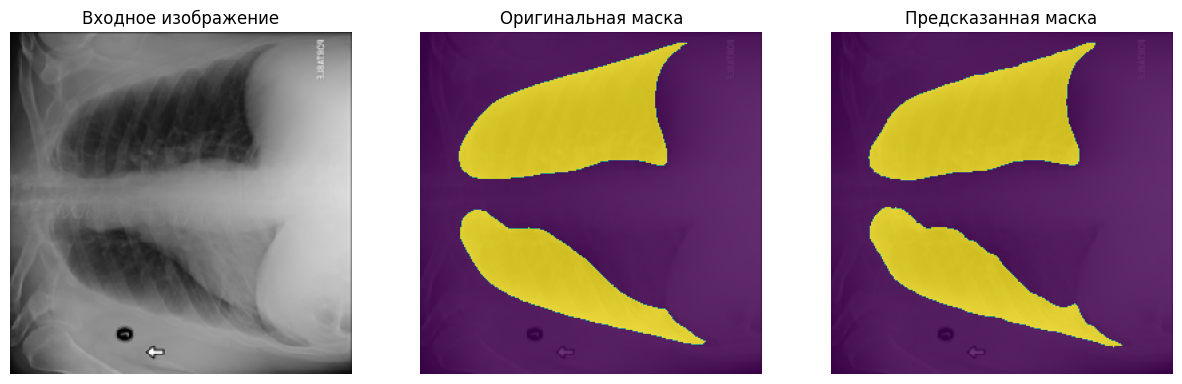

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


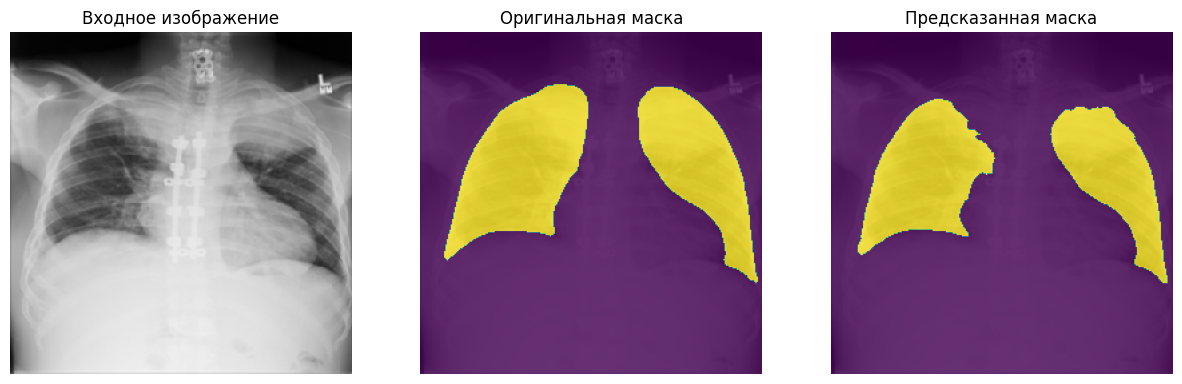

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


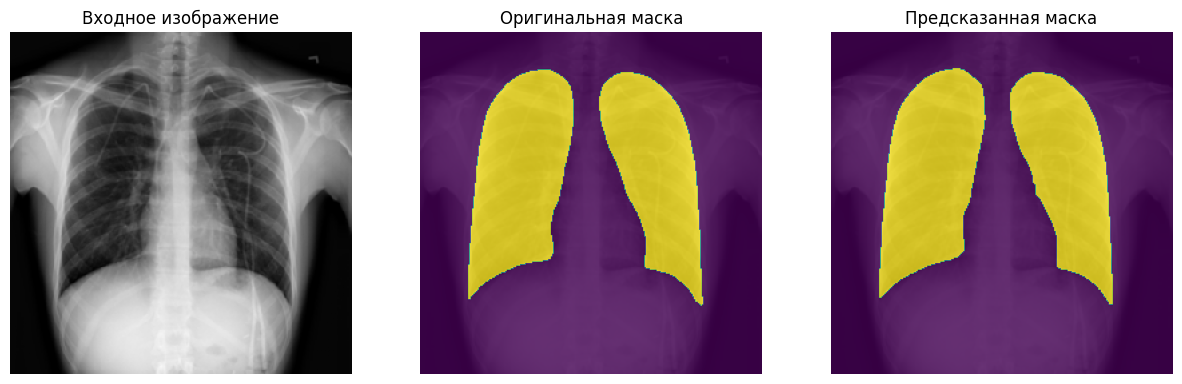

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


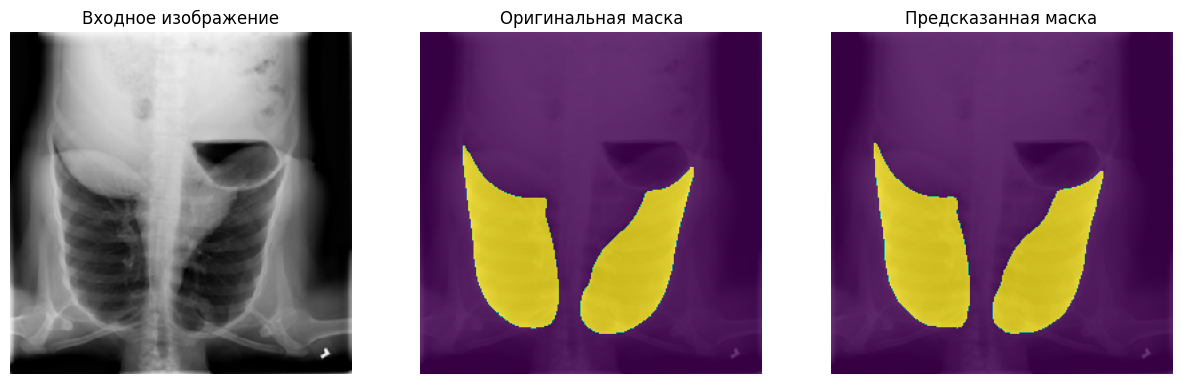

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


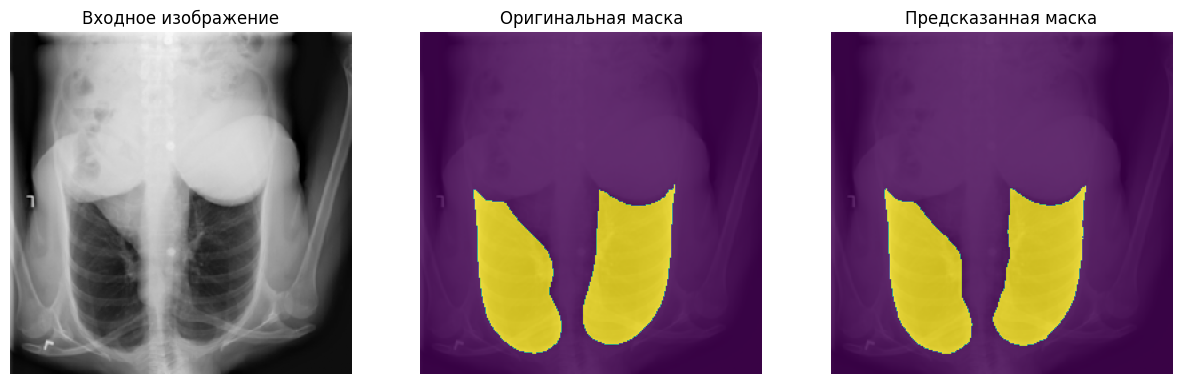

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


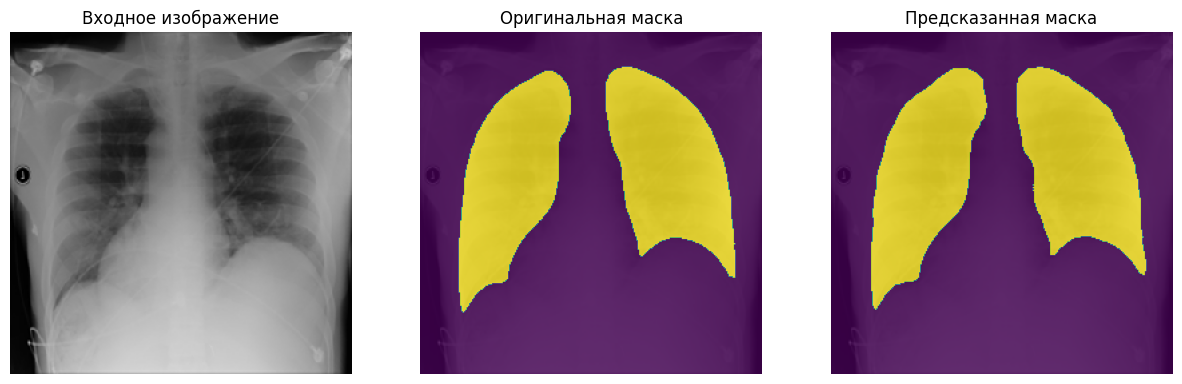

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


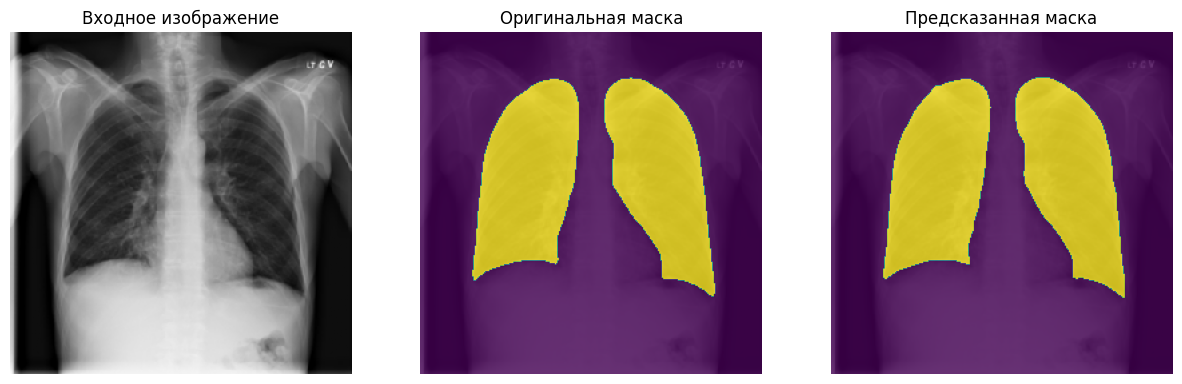

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


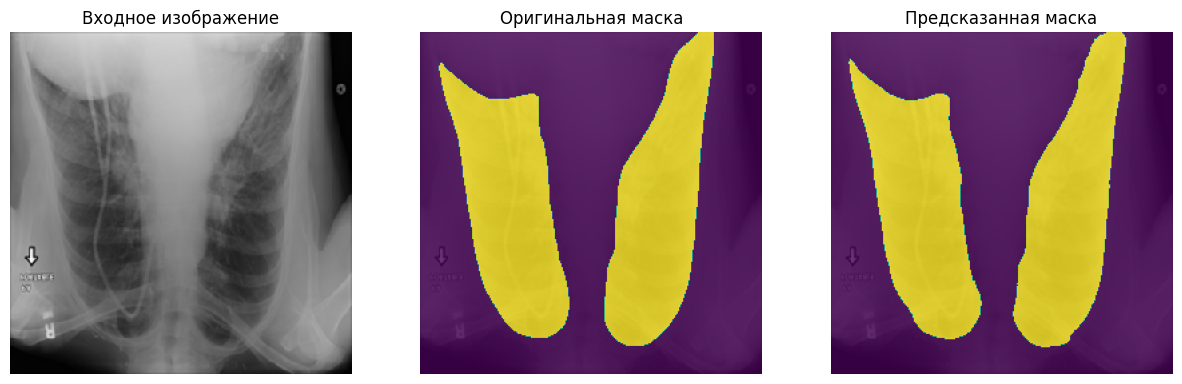

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


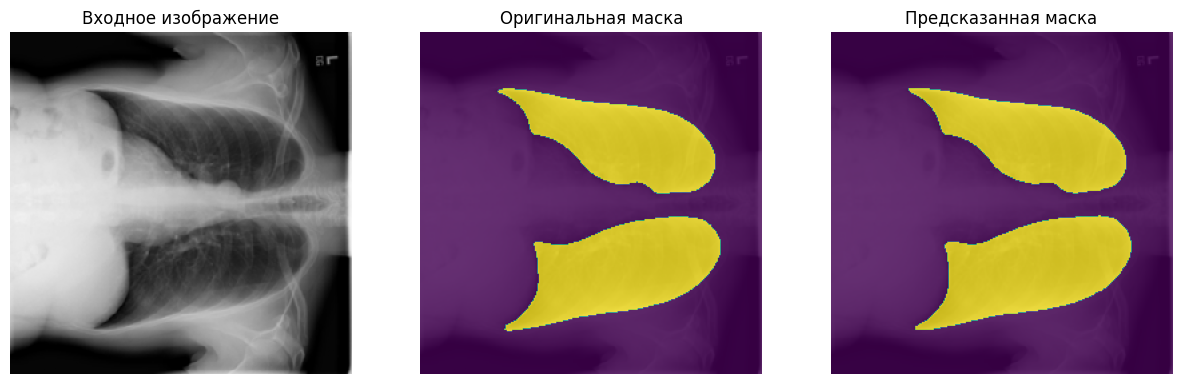

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


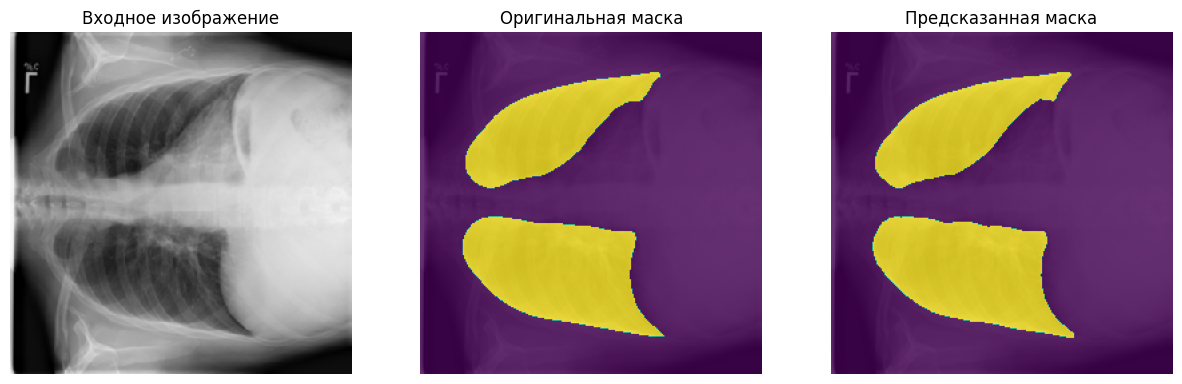

In [ ]:
c = 0
for dp in val_gen:
  x = dp[0][0]
  y = dp[1][0]
  pred = model.predict(np.expand_dims(x, axis=0))
  arr = np.argmax(pred[0], axis=-1)
  y = np.argmax(y, axis=-1)
  display([x, y, arr])
  c += 1
  if c == 10:
    break



def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])
    plt.imshow(display_list[i],alpha=0.8)
    plt.axis('off')
  plt.show()


